In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,precision_score,precision_score,recall_score,precision_recall_curve,auc,classification_report
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from collections import Counter
from imblearn.over_sampling import SMOTENC

# Business Understanding: Predicting Water Pump Functionality in Tanzania

## Problem Statement
Tanzania faces significant challenges in maintaining its water infrastructure. Many pumps fail unexpectedly, causing water shortages that impact community health and development. Current maintenance approaches are reactive, leading to inefficient resource allocation and preventable service disruptions. 

This project addresses this problem by developing a predictive model that classifies water pumps into three categories:
- **Functional**: Operating normally
- **Needs repairs**: Requiring maintenance
- **Non functional**: Not operational

## Stakeholders and Applications
### Tanzanian Water Authorities
- Prioritize maintenance resources for high-risk pumps
- Optimize repair schedules and budget allocation

### NGOs and Aid Organizations
- Target interventions to prevent failures in vulnerable regions
- Evaluate infrastructure investment effectiveness

### Local Maintenance Teams
- Receive actionable alerts for pumps needing immediate attention
- Reduce response time for critical repairs

## Project Impact
Successful implementation would:
- Improve water access reliability for communities
- Reduce maintenance costs through proactive interventions
- Enable data-driven infrastructure planning
- Support sustainable development goals for clean water access

This solution directly addresses a critical infrastructure challenge affecting millions in Tanzania, transforming maintenance from reactive to predictive.

In [4]:
train_features = pd.read_csv('training_set_values.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_values.csv')
df = pd.merge(train_features,train_labels,on='id')


## Data Understanding

The dataset contains 40 features describing water pumps across Tanzania, with approximately 59,400 records. Key feature categories:

### Geographic Features
- **Location**: `longitude`, `latitude`, `gps_height`, `basin`, `region`, `district_code`, `ward`
- **Population**: `population` (around pump), `subvillage`

### Waterpoint Characteristics
- **Technical specs**: `extraction_type` (with class/group), `waterpoint_type`, `source` (with type/class)
- **Water properties**: `water_quality`, `quantity` (both with grouped versions)
- **Infrastructure**: `construction_year`, `amount_tsh` (water availability)

### Management & Administration
- **Funding/Installation**: `funder`, `installer`
- **Operations**: `management` (with group), `scheme_management`
- **Permissions**: `permit`, `public_meeting`
- **Payment models**: `payment_type`

### Temporal & Recording Data
- `date_recorded` (entry date)
- `recorded_by` (data entry entity)

### Target Variable
- `status_group`: Classification target (Functional, Non Functional, Functional Needs Repair)

### Initial Observations
1. **Geographic dominance**: 20+ spatial features enable regional analysis
2. **Redundancies**: Multiple grouped features (`*_type` + `*_group`) will need consolidation because they give the same info
3. **Administrative focus**: ~15 features track management/funding aspects

In [5]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [6]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [111]:
df1 = pd.merge(train_features,train_labels,on='id')
df1.drop(axis=1,columns='scheme_name')
df1.dropna(inplace=True)
df1.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
13,50495,0.0,2013-03-15,Lawatefuka Water Supply,1368,Lawatefuka water sup,37.092574,-3.181783,Kwa John Izack Mmari,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
14,53752,0.0,2012-10-20,Biore,0,WEDECO,34.364073,-3.629333,Mwabasabi,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


Let us Visualize the failure rate of the pumps vs the age of the pump.

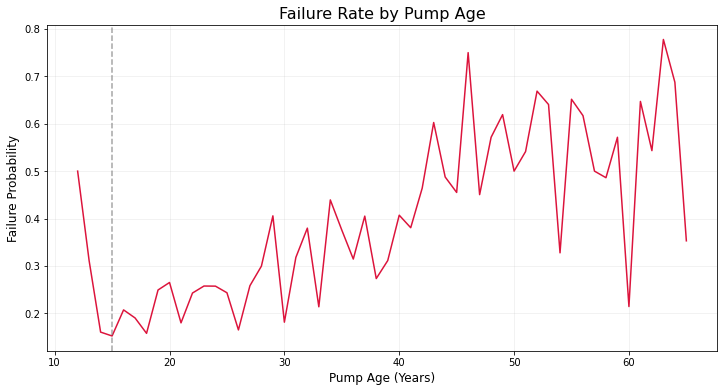

In [119]:
# Create pump age feature
current_year = 2025
df1['pump_age'] = current_year - df1['construction_year']
df1 = df1[df1['pump_age'] <= 300]

plt.figure(figsize=(12,6))
sns.lineplot(x='pump_age', y='failure', 
             data=df1.assign(failure=(df1['status_group']=='non functional').astype(int)),
             ci=None, color='crimson', estimator='mean')
plt.title('Failure Rate by Pump Age', fontsize=16)
plt.xlabel('Pump Age (Years)', fontsize=12)
plt.ylabel('Failure Probability', fontsize=12)
plt.axvline(x=15, color='grey', linestyle='--', alpha=0.7)
plt.grid(alpha=0.2)
plt.show()

As one can see the failure rate of pumps is increasing as the age of the pump increases

Lets take a look at the failure rate of pumps per region

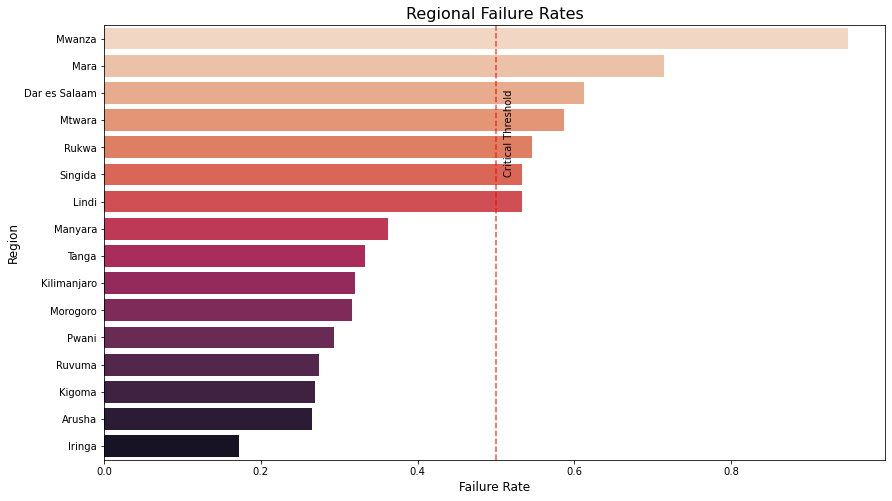

In [125]:
plt.figure(figsize=(14,8))
region_failure = df1.groupby('region')['status_group'].apply(
    lambda x: (x=='non functional').mean()).sort_values(ascending=False)

sns.barplot(x=region_failure.values, y=region_failure.index, palette='rocket_r')
plt.title('Regional Failure Rates', fontsize=16)
plt.xlabel('Failure Rate', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
plt.text(0.51, 5, 'Critical Threshold', rotation=90, fontsize=10)
plt.show()

We can see that the top regions with failure are Mwanza, Mara, Dar es Salaam, Mtwara and Rukwa.

From the graph below we can see that the top regions with failure are the same regions with the lowest population being served by the well.

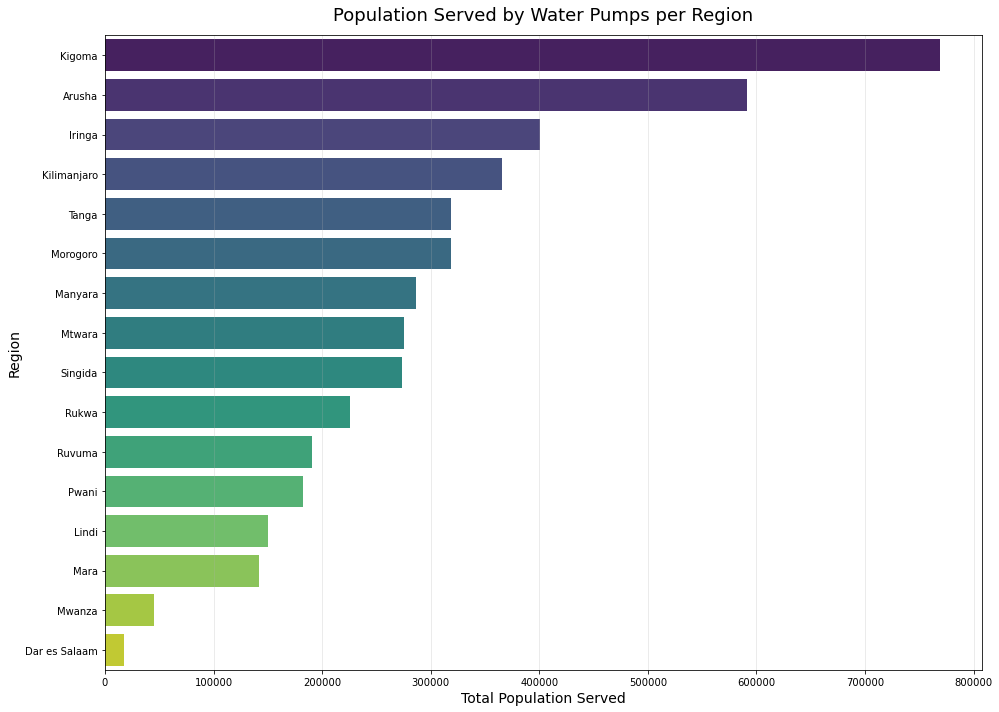

In [128]:
# Prepare data
region_pop = df1.groupby('region')['population'].sum().sort_values(ascending=False)

plt.figure(figsize=(14,10))
ax = sns.barplot(x=region_pop.values, y=region_pop.index, palette='viridis')


plt.title('Population Served by Water Pumps per Region', fontsize=18, pad=15)
plt.xlabel('Total Population Served', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

From the graph below we can see that the regions that have the highest pump failure rate also have the oldest pumps. 

We can conclude that pump age is a large factor when it comes to the condition of the pump.

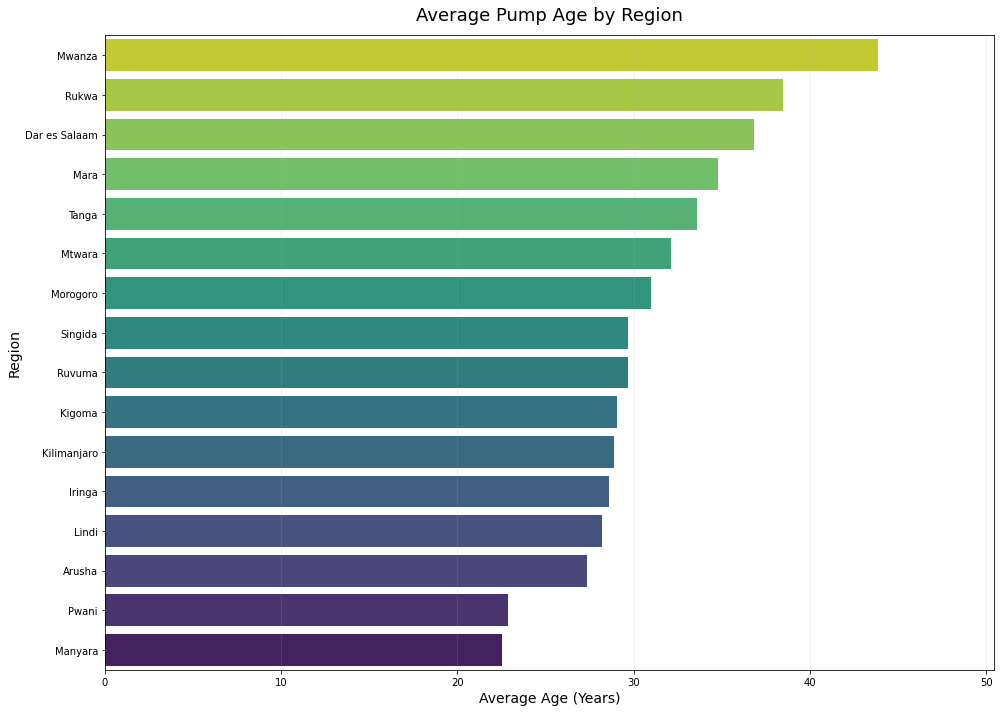

In [130]:
# Calculate average pump age per region
region_age = df1.groupby('region')['pump_age'].mean().sort_values(ascending=False)

# Create visualization
plt.figure(figsize=(14,10))
ax = sns.barplot(x=region_age.values, y=region_age.index, palette='viridis_r')


# Formatting
plt.title('Average Pump Age by Region', fontsize=18, pad=15)
plt.xlabel('Average Age (Years)', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.xlim(0, region_age.max() * 1.15)
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

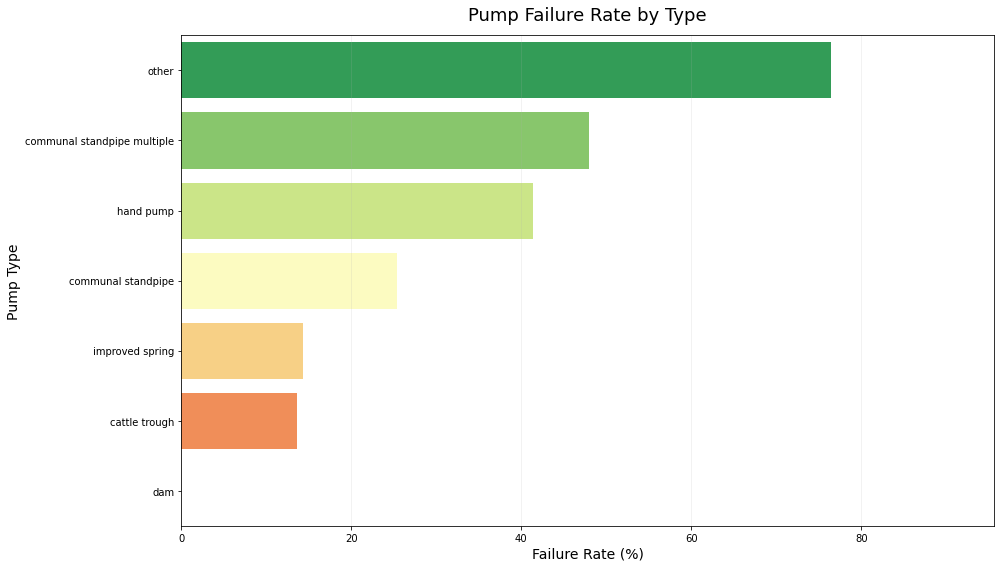

In [136]:

# Calculate failure rates by pump type
pump_failure = df1.groupby('waterpoint_type')['status_group'].apply(
    lambda x: (x == 'non functional').mean() * 100
).sort_values(ascending=False).reset_index(name='failure_rate')

# Create visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='failure_rate', 
    y='waterpoint_type', 
    data=pump_failure,
    palette='RdYlGn_r',  # Red-Yellow-Green reversed (red = high failure)
    saturation=0.9
)

# Formatting
plt.title('Pump Failure Rate by Type', fontsize=18, pad=15)
plt.xlabel('Failure Rate (%)', fontsize=14)
plt.ylabel('Pump Type', fontsize=14)
plt.xlim(0, pump_failure['failure_rate'].max() * 1.25)
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

## Data Preparation

### Column Removal Strategy
Removed the following columns due to redundancy or lack of predictive value:

1. **Geographic Redundancies**  
   Kept: `longitude`, `latitude`, `gps_height`, `basin`  
   Removed: `region`, `region_code`, `district_code`, `lga`, `ward`, `subvillage`  
   *Reason: Latitude/Longitude provide precise location; other features add duplication*

2. **Grouped Feature Redundancies**  
   Kept the most fundamental version of each feature group:  
   - `extraction_type_class` (removed `extraction_type`, `extraction_type_group`)
   - `source_class,source_type` (removed `source`)
   - `waterpoint_type` (removed `waterpoint_type_group`)
   - `quality_group` (removed `water_quality`)
   - `quantity_group` (removed `quantity`)
   - `payment_type` (removed `payment`)
   - `management_group` (removed `management`)

3. **Administrative Columns**  
   Removed: `funder`, `installer`, `scheme_management`, `scheme_name`, `recorded_by`, `wpt_name`  
   *Reason: Organizational metadata unlikely to correlate with pump functionality*

4. **Other Columns**  
   Removed: `date_recorded` (I will replace this column with year_recorded instead)
   *Reason: The other date-time column is in years. I would like all the date-time columns to be in years.*

### Resulting Dataset
- **Features retained**: 11 core attributes  
- **Key preserved features**:  
  - Physical: `amount_tsh`, `gps_height`, `population`, `construction_year`, `basin`,`longitude`,`latitude`  
  - Technical: `extraction_type_class`, `source_class`, `waterpoint_type_group`  
  - Operational: `management_group`, `payment_type`, `quality_group`, `quantity_group`
  - Administrative: `permit`, `public_meeting` 
- **Target**: `status_group` (functionality classification)

This refined dataset eliminates noise while preserving features with clear mechanistic relationships to pump functionality.

In [9]:
cols_to_remove = ['scheme_name','source','waterpoint_type_group','quantity','extraction_type',
                  'extraction_type_group','water_quality','id','funder','subvillage','region','region_code',
                  'district_code','lga','ward','recorded_by','scheme_management','wpt_name','payment',
                  'extraction_type','installer','management']

df.drop(inplace=True,axis=1,columns=cols_to_remove)

In the cell below we will look for the columns that have null values

In [10]:
df.isna().any()[df.isna().any() == True]

public_meeting    True
permit            True
dtype: bool

In the cell below we will confirm the percentage of null values in the dataset.

In [11]:
df.isna().mean()[df.isna().mean() > 0]

public_meeting    0.056128
permit            0.051448
dtype: float64

The Scheme_Name columns has about 47% missing data. I will drop this column.

I will also drop the null rows of the other columns since they consist of a small percentage of the data (<7%).

In [12]:
df.dropna(inplace=True)

We will confirm that the null values have been dropped

In [13]:
df.isna().mean()[df.isna().mean() > 0]

Series([], dtype: float64)

The empty list that was returned has confirmed that there are no null columns with any null values in the dataset.

We will add a column called Year Recorded.

We will then drop the Date_Recorded column

In [14]:
df['Year_Recorded'] = df['date_recorded'].str.slice(0,4)

In [15]:
df[['date_recorded','Year_Recorded']]

,date_recorded,Year_Recorded
0,2011-03-14,2011
2,2013-02-25,2013
3,2013-01-28,2013
4,2011-07-13,2011
5,2011-03-13,2011
...,...,...
59395,2013-05-03,2013
59396,2011-05-07,2011
59397,2011-04-11,2011
59398,2011-03-08,2011


In [16]:
df['Year_Recorded'] = df['Year_Recorded'].astype('int64')

In [17]:
df['Year_Recorded'].unique()

array([2011, 2013, 2012, 2004, 2002], dtype=int64)

We will now drop the date_recorded column

In [18]:
df.drop(axis=1,columns=['date_recorded'],inplace=True)

Now that I am finished dropping columns I want to ensure the data is balanced.

In order to know if the data is balanced I will be looking at the number of instances of each category in the target variable.

The target variable is status_group.

I will do a value counts on this target variable.


In [19]:
df.status_group.value_counts()

functional                 29065
non functional             20349
functional needs repair     3867
Name: status_group, dtype: int64

As one can see the data is very unbalanced.

The functional category has 26,517 entries.

While the non-functional category has 18,273 columns.

Lastly, the functional-needs-repair category has 3498 entries.

I will use random undersampling on the functional and non-functional entries to make sure they have 15,000 entries.

I am undersampling so that the majority classes are closer to the minority class. I will use SMOTE on X_train so that the minority class can match the two majority classes during the training. That will be later after the data is split.

In [20]:
#creating seperate dataframes that only have 1 one each category
df_functional = df[df['status_group'] == 'functional']
df_non_functional = df[df['status_group'] == 'non functional']
df_functional_needs_repair = df[df['status_group'] == 'functional needs repair']

#picking 15,000 random samples from the two majority classes
functional_samples = df_functional.sample(n=15000,random_state=42)
non_functional_samples = df_non_functional.sample(n=15000,random_state=42)



In [21]:
#combining the undersampled functional and non-functional categories
df_undersampled = pd.concat([functional_samples,non_functional_samples])

#combining the df_undersampled with the functional-needs-repair category
#we are not undersampling functional-needs-repair category because it is still the minority sample
final_df_undersampled = pd.concat([df_undersampled,df_functional_needs_repair])
final_df_undersampled.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type,status_group,Year_Recorded
34415,0.0,0,32.274568,-3.814714,0,Lake Tanganyika,0,True,True,0,other,user-group,unknown,milky,enough,shallow well,groundwater,other,functional,2012
43329,500.0,335,37.043403,-7.549873,0,Rufiji,170,True,True,1981,handpump,user-group,monthly,good,enough,shallow well,groundwater,hand pump,functional,2011
39956,0.0,0,32.891355,-8.986656,0,Lake Rukwa,0,True,False,0,handpump,user-group,on failure,good,enough,shallow well,groundwater,hand pump,functional,2011
44764,0.0,0,32.503323,-3.918842,0,Lake Tanganyika,0,True,True,0,handpump,user-group,unknown,milky,enough,borehole,groundwater,hand pump,functional,2012
58383,4000.0,2124,34.570664,-9.344111,0,Lake Nyasa,15,True,True,2010,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,2011


In [22]:
#checking we have 15,000 counts of the majority classes
final_df_undersampled.status_group.value_counts()

functional                 15000
non functional             15000
functional needs repair     3867
Name: status_group, dtype: int64

In [23]:
# list = []
# for id,name in enumerate(X_train.columns.tolist()):
#     if name not in num_cols:
#         list.append((id,name))
# # print(list)
# print(list)

# categorical_id = []
# for i in list:
#     categorical_id.append(i[0])

# print(categorical_id)

## Modeling

### Approach
1. **Class Imbalance Handling**: Apply SMOTE to balance training data
2. **Baseline Model**: Logistic Regression with default parameters
3. **Model Improvement**: Hyperparameter tuning for optimization
4. **Evaluation Metric**: Focus on recall for "non functional" class (most critical failure case)

I will now split the data and use SMOTE to create synthetic data of the minority category.

The process for SMOTE will go as such:

1. Split the data using train_test_split ensure stratify=y argument to maintain the original split of the data.

2. Use Counter(y_train) to find out the split of the data.

3. Create two lists one for the categorical features and one for the numerical features.

4. Create a copy of X_train and X_test

5. Do ordinal encoding on the copies.

6. Call an instance of SMOTENC.

7. Fit_resample on X_train_ord,y_train

8. Perform OneHotEncoding on the resampled dataframe. (remember the output will be a numpy array)

9. Extract the numerical features from the resampled dataframe.

10. Recreate the X_train and X_test dataframes

11. Perform Label Encoding on y_train and y_test

I can see that category 1 is under represented in the y_train data.

I will use SMOTENC to generate synthetic entries of category 1 to make sure that it has 12,000 entries so the dataset is  balanced.

In [24]:
# 1. FIRST: Split Data into Train/Test Sets
# =====================================================================
X = final_df_undersampled.drop('status_group', axis=1)
y = final_df_undersampled['status_group']

# Stratify to preserve imbalance ratio in splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

print("\nTraining set class distribution:")
print(Counter(y_train))  # e.g., A:560, B:160, C:80


Training set class distribution:
Counter({'functional': 12000, 'non functional': 12000, 'functional needs repair': 3093})


In [25]:
from sklearn.preprocessing import MinMaxScaler
#Identify numerical columns
num_cols = ['amount_tsh', 'longitude', 'latitude', 'num_private', 'population','construction_year','Year_Recorded','gps_height']
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols]) 
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [26]:
X_train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type,Year_Recorded
16886,0.00008,0.031469,0.951766,0.558347,0.0,Pangani,0.025163,True,True,0.997516,handpump,user-group,per bucket,good,insufficient,shallow well,groundwater,hand pump,0.777778
17924,0.00008,0.419231,0.916157,0.479169,0.0,Wami / Ruvu,0.005882,True,True,0.998510,gravity,user-group,per bucket,good,enough,spring,groundwater,communal standpipe,0.777778
25329,0.00000,0.031469,0.881347,0.459539,0.0,Internal,0.000000,True,False,0.000000,gravity,user-group,never pay,good,dry,spring,groundwater,other,0.777778
1893,0.00000,0.351748,0.915289,0.692759,0.0,Pangani,0.013072,True,True,0.997019,handpump,user-group,unknown,salty,enough,shallow well,groundwater,hand pump,1.000000
32036,0.00000,0.031469,0.819245,0.236239,0.0,Lake Rukwa,0.000000,False,False,0.000000,handpump,user-group,on failure,good,seasonal,shallow well,groundwater,hand pump,0.777778


In [27]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type,Year_Recorded
26502,0.00004,0.550350,0.885670,0.711933,0.0,Internal,0.006536,True,True,0.992548,gravity,user-group,per bucket,good,enough,river/lake,surface,communal standpipe,1.000000
25373,0.00000,0.497552,0.880032,0.743911,0.0,Internal,0.016340,True,False,0.996523,gravity,user-group,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,1.000000
52364,0.00000,0.031469,0.827361,0.731679,0.0,Lake Victoria,0.000000,True,True,0.000000,handpump,user-group,never pay,good,enough,shallow well,groundwater,hand pump,0.777778
9794,0.00000,0.031469,0.837556,0.182276,0.0,Lake Nyasa,0.000000,True,True,0.000000,gravity,user-group,never pay,good,dry,spring,groundwater,communal standpipe,0.777778
32811,0.00000,0.031469,0.790862,0.721150,0.0,Lake Tanganyika,0.000000,True,True,0.000000,handpump,parastatal,unknown,good,insufficient,shallow well,groundwater,hand pump,0.888889


In [28]:
final_df_undersampled.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type,status_group,Year_Recorded
34415,0.0,0,32.274568,-3.814714,0,Lake Tanganyika,0,True,True,0,other,user-group,unknown,milky,enough,shallow well,groundwater,other,functional,2012
43329,500.0,335,37.043403,-7.549873,0,Rufiji,170,True,True,1981,handpump,user-group,monthly,good,enough,shallow well,groundwater,hand pump,functional,2011
39956,0.0,0,32.891355,-8.986656,0,Lake Rukwa,0,True,False,0,handpump,user-group,on failure,good,enough,shallow well,groundwater,hand pump,functional,2011
44764,0.0,0,32.503323,-3.918842,0,Lake Tanganyika,0,True,True,0,handpump,user-group,unknown,milky,enough,borehole,groundwater,hand pump,functional,2012
58383,4000.0,2124,34.570664,-9.344111,0,Lake Nyasa,15,True,True,2010,gravity,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,2011


We will need to make sure the 'functional needs repair' category reaches 12,000 entries using smote

In [29]:
final_df_undersampled.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'basin', 'population', 'public_meeting', 'permit', 'construction_year',
       'extraction_type_class', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'source_class',
       'waterpoint_type', 'status_group', 'Year_Recorded'],
      dtype='object')

In [30]:
# 2. Preprocess Categorical Features with ORDINAL ENCODING (For SMOTENC compatibility)
# Identify categorical columns
cat_cols = ['permit','extraction_type_class','management_group', 'payment_type', 'quality_group', 'quantity_group',
            'source_type', 'source_class', 'waterpoint_type','basin','public_meeting']

#Identify numerical columns
num_cols = ['amount_tsh', 'longitude', 'latitude', 'num_private', 'population','construction_year','Year_Recorded','gps_height']

# Initialize and fit ordinal encoder on TRAINING DATA ONLY
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord = X_train.copy()
X_train_ord[cat_cols] = ordinal_encoder.fit_transform(X_train[cat_cols])

# Apply to test data using same encoder
X_test_ord = X_test.copy()
X_test_ord[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

In [31]:
# 3. Apply SMOTENC to Training Data
# Get categorical feature indices (positions after encoding)
cat_idx = [X_train_ord.columns.get_loc(col) for col in cat_cols]

# Define resampling strategy
sampling_strategy = {'functional needs repair': 12000}  # Upsample to match majority

sm = SMOTENC(
    categorical_features=cat_idx,
    sampling_strategy=sampling_strategy,
    k_neighbors=5,
    random_state=42
)

# Apply SMOTENC to ordinal-encoded training data
X_train_res, y_train_res = sm.fit_resample(X_train_ord, y_train)

print("\nAfter SMOTENC resampling:")
print(Counter(y_train_res))  # A:12000, B:12000, C:12000

c:\Users\franc\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



After SMOTENC resampling:
Counter({'functional': 12000, 'non functional': 12000, 'functional needs repair': 12000})


In [32]:
# 4. Apply ONE-HOT ENCODING (After SMOTENC)
# =====================================================================
# Initialize and fit one-hot encoder on RESAMPLED training data
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = onehot_encoder.fit_transform(X_train_res[cat_cols])

# Apply to test data using same encoder
X_test_ohe = onehot_encoder.transform(X_test_ord[cat_cols])

In [33]:
# 5. Combine Features for Final Dataset
# =====================================================================
# Extract numerical features (unchanged)
X_train_num = X_train_res[num_cols].reset_index(drop=True)
X_test_num = X_test_ord[num_cols].reset_index(drop=True)

# Create feature names for one-hot encoded columns
ohe_columns = onehot_encoder.get_feature_names_out(cat_cols)

# Combine numerical and one-hot categorical features
X_train_final = pd.concat([X_train_num, pd.DataFrame(X_train_ohe, columns=ohe_columns)], axis=1)

X_test_final = pd.concat([X_test_num, pd.DataFrame(X_test_ohe, columns=ohe_columns)], axis=1)

In [34]:
# Encoding target variable 
label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_res)
y_test_final = label_encoder.transform(y_test)

In [35]:
y_train_final

array([0, 2, 2, ..., 1, 1, 1])

In [36]:
y_train_res.head()

0        functional
1    non functional
2    non functional
3    non functional
4    non functional
Name: status_group, dtype: object

Lets remember the encoding of the target

'non_functional' : 2

'functional needs repair' : 1

'functional' : 0

In [37]:
print("\nFinal training set shape:", X_train_final.shape)
print("Final test set shape:", X_test_final.shape)
print("Sample of final training data:")
X_train_final.head()


Final training set shape: (36000, 68)
Final test set shape: (6774, 68)
Sample of final training data:


,amount_tsh,longitude,latitude,num_private,population,construction_year,Year_Recorded,gps_height,permit_0.0,permit_1.0,...,basin_1.0,basin_2.0,basin_3.0,basin_4.0,basin_5.0,basin_6.0,basin_7.0,basin_8.0,public_meeting_0.0,public_meeting_1.0
0,0.00008,0.951766,0.558347,0.0,0.025163,0.997516,0.777778,0.031469,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.00008,0.916157,0.479169,0.0,0.005882,0.998510,0.777778,0.419231,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.00000,0.881347,0.459539,0.0,0.000000,0.000000,0.777778,0.031469,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.00000,0.915289,0.692759,0.0,0.013072,0.997019,1.000000,0.351748,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.00000,0.819245,0.236239,0.0,0.000000,0.000000,0.777778,0.031469,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Baseline Model Perfomance:

We will use LogisticRegression default to find the baseline perfomance of the model.

In [64]:
model = LogisticRegression(random_state=42)
model.fit(X_train_final,y_train_final)
y_pred = model.predict(X_test_final)
print(classification_report(y_test_final,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65      3000
           1       0.26      0.57      0.36       774
           2       0.81      0.59      0.68      3000

    accuracy                           0.61      6774
   macro avg       0.58      0.60      0.57      6774
weighted avg       0.68      0.61      0.63      6774



c:\Users\franc\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Performance of the model

We can see the model had an accuracy of 0.61.

The model also had an average recall score of 0.60 and a weighted average recall of 0.61.

This performance is a little poor. 

The metric that we will focus on the most is the recall of category 2 (non-functional) which was 0.59.

We will be using hyperparameter tuning to try improve the recall and the accuracry of the model.

In the following cell I will be creating a function that will store the results of the hyperparameter tuning in a dataframe.

I will use this to store the results of the different models so that we can choose the one with both a good recall and accuracy.

In [55]:
def gridsearch_results(X, y, models_param_grids, cv=5, scoring=None):
    """
    Perform GridSearchCV for multiple models and return results in a DataFrame.
    
    Parameters:
    X (array-like): Feature matrix
    y (array-like): Target vector
    models_param_grids (dict): Dictionary of model names and (estimator, param_grid) tuples
    cv (int): Cross-validation folds
    scoring (dict): Scoring metrics (default: {'accuracy', 'precision', 'recall'})
    
    Returns:
    pd.DataFrame: Results with model names, parameters, and metrics
    """
    from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
    
    # Default scoring metrics (binary classification)
    if scoring is None:
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='weighted', zero_division=0),
            'recall': make_scorer(recall_score, average='weighted', zero_division=0)
        }
    
    results = []
    
    for model_name, (estimator, param_grid) in models_param_grids.items():
        # Set up GridSearchCV with multiple metrics
        gs = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1, #for parallel processing
            verbose=1,
            refit=False,  # We'll collect all results, not just the best
            return_train_score=False,
            error_score='raise'
        )
        gs.fit(X, y)
        
        # Collect results for each parameter combination
        for i in range(len(gs.cv_results_['params'])):
            result = {
                'model': model_name,
                'params': gs.cv_results_['params'][i],
                'accuracy': gs.cv_results_['mean_test_accuracy'][i],
                'precision': gs.cv_results_['mean_test_precision'][i],
                'recall': gs.cv_results_['mean_test_recall'][i]
            }
            results.append(result)
    
    return pd.DataFrame(results),gs

In [56]:
logReg_param_grid = {'LogisticRegressionL1':(
        LogisticRegression(random_state=42),{
    # Regularization strength (inverse of lambda)
    'C': [0.01,0.1, 1, 10, 100,500],  
    
    # Regularization type (L1/L2)
    'penalty': ['l1', 'l2'],  
    
    # Optimization algorithms
    'solver': ['liblinear', 'saga'],  
    
    # # Class weighting (adjust for residual imbalance)
    # 'class_weight': [None, {0:1, 1:2, 2:1.5}],
    
    # Maximum iterations for convergence
    'max_iter': [1500],
    
    # # Tolerance for stopping criteria
    # 'tol': [1e-4, 1e-3, 1e-2]
}) }



In [57]:
logReg_results_df,model = gridsearch_results(X_train_final, y_train_final, logReg_param_grid)

logReg_results_df.head(10).sort_values('accuracy',ascending=False)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,model,params,accuracy,precision,recall
9,LogisticRegressionL1,"{'C': 1, 'max_iter': 1500, 'penalty': 'l1', 's...",0.623444,0.635811,0.623444
7,LogisticRegressionL1,"{'C': 0.1, 'max_iter': 1500, 'penalty': 'l2', ...",0.622583,0.634677,0.622583
8,LogisticRegressionL1,"{'C': 1, 'max_iter': 1500, 'penalty': 'l1', 's...",0.620806,0.633759,0.620806
5,LogisticRegressionL1,"{'C': 0.1, 'max_iter': 1500, 'penalty': 'l1', ...",0.618028,0.631038,0.618028
6,LogisticRegressionL1,"{'C': 0.1, 'max_iter': 1500, 'penalty': 'l2', ...",0.617000,0.629912,0.617000
3,LogisticRegressionL1,"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2',...",0.616250,0.628216,0.616250
4,LogisticRegressionL1,"{'C': 0.1, 'max_iter': 1500, 'penalty': 'l1', ...",0.615222,0.628421,0.615222
2,LogisticRegressionL1,"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2',...",0.613528,0.625254,0.613528
1,LogisticRegressionL1,"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l1',...",0.607333,0.622567,0.607333
0,LogisticRegressionL1,"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l1',...",0.606917,0.620721,0.606917


The best logistic regression model found by our gridsearch cv has the following parameters

In [62]:
logReg_results_df.loc[9,'params']

{'C': 1, 'max_iter': 1500, 'penalty': 'l1', 'solver': 'saga'}

It has the following perfomance

In [67]:
model = LogisticRegression(random_state=42,C= 1, max_iter= 10000,penalty= 'l1', solver= 'saga')
model.fit(X_train_final,y_train_final)
y_pred = model.predict(X_test_final)
print(classification_report(y_test_final,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.66      3000
           1       0.26      0.58      0.36       774
           2       0.80      0.59      0.68      3000

    accuracy                           0.61      6774
   macro avg       0.58      0.60      0.57      6774
weighted avg       0.68      0.61      0.63      6774



The model has the same accuracy and recall with values of 0.61 and 0.60.

The model must be underfitting due to it not being complex enough.

I propose that we try the same hyperparameter tuning with the decision tree to see if the performance improves.

We will begin with the base performance of a decision tree classifier then conduct the hyperparameter tuning

### Performance of baseline DecisionTree model

From the cell below we can see a very big increase in perfomance from the decision tree classifier.

The model has an accuracy of 0.71, with an average recall of 0.67.

The recall for category 2 (non-functional) is 0.77, which is very good compared to the 0.59 we got from the logistic regression

In [47]:
model2 = DecisionTreeClassifier()
model2.fit(X_train_final,y_train_final)
y_pred2 = model2.predict(X_test_final)
print(classification_report(y_test_final,y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      3000
           1       0.42      0.54      0.47       774
           2       0.79      0.77      0.78      3000

    accuracy                           0.71      6774
   macro avg       0.65      0.67      0.66      6774
weighted avg       0.72      0.71      0.72      6774



In [74]:

models_param_grids = {
    'DecisionTree': (
        DecisionTreeClassifier(random_state=42),
        {'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'criterion': ['gini','entropy']
    } ) }



In [75]:
# # Get results
results_df,model = gridsearch_results(X_train_final, y_train_final, models_param_grids, cv=10)


Fitting 10 folds for each of 640 candidates, totalling 6400 fits


In [76]:
results_df.head(15).sort_values('accuracy',ascending=False)

,model,params,accuracy,precision,recall
1,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.757139,0.756742,0.757139
2,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.756333,0.758665,0.756333
0,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.756278,0.756026,0.756278
3,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.753528,0.758310,0.753528
5,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.752083,0.755615,0.752083
4,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.751250,0.754050,0.751250
7,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.741194,0.743996,0.741194
6,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.741000,0.743647,0.741000
8,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.333333,0.111111,0.333333
9,DecisionTree,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.333333,0.111111,0.333333


### Performance of the best DecisionTreeClassifier

In the cell below we will get the model parameters of the best performing decision tree classifier

In [77]:
results_df.loc[1,'params']

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 2,
 'splitter': 'random'}

The parameters look similar to that of a default decision tree

In [ ]:
model2 = DecisionTreeClassifier(criterion= 'gini',
 max_depth= None,
 max_features= 'sqrt',
 min_impurity_decrease= 0.0,
 min_samples_split= 2,
 splitter= 'random')
model2.fit(X_train_final,y_train_final)
y_pred2 = model2.predict(X_test_final)
print(classification_report(y_test_final,y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72      3000
           1       0.43      0.58      0.49       774
           2       0.78      0.77      0.77      3000

    accuracy                           0.71      6774
   macro avg       0.65      0.68      0.66      6774
weighted avg       0.72      0.71      0.72      6774



In [ ]:
model2.coe

The perfomance of the decision tree classifier is the same as that of the default decision tree.

There was a small improvement in the average recall which increased from 0.67 to 0.68.

Other than that the recall of category 2 (non-functional) and the accuracy remained the same.

However the perfomance of the decision tree is much better than that of the logistic regression there was an improvement of 10%.

We will finally try using the RandomForestClassifier


### Default Performance of RandomForestClassifier

In [90]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()
model2.fit(X_train_final,y_train_final)
y_pred2 = model2.predict(X_test_final)
print(classification_report(y_test_final,y_pred2))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      3000
           1       0.48      0.58      0.52       774
           2       0.83      0.80      0.81      3000

    accuracy                           0.76      6774
   macro avg       0.69      0.71      0.70      6774
weighted avg       0.76      0.76      0.76      6774



The accuracy of the RandomFOrestClassifier is 0.76 which is a 5% improvement on the performance of the DecisionTreeClassifier

I will now set some model parameters for RandomForestClassifier to see if there are any parameters that perform better than the default.

In [93]:
from sklearn.ensemble import RandomForestClassifier

models_param_grids = {
    'DecisionTree': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100,200,400],          # Fewer trees for speed
    'max_features': ['sqrt', 0.5],      # Feature sampling
    'bootstrap': [True, False]          # With/without replacement
    } ) }

In [94]:
results_df,model = gridsearch_results(X_train_final, y_train_final, models_param_grids, cv=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


We will check to see which model parameters performed the best below.

We will then check the parameters of the best performing RandomForestClassifier

In [101]:
results_df.sort_values('accuracy',ascending=False).head(10)

,model,params,accuracy,precision,recall
2,DecisionTree,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",0.809306,0.809999,0.809306
6,DecisionTree,"{'bootstrap': True, 'max_features': 0.5, 'n_es...",0.809194,0.809932,0.809194
7,DecisionTree,"{'bootstrap': True, 'max_features': 0.5, 'n_es...",0.809028,0.809696,0.809028
3,DecisionTree,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",0.808972,0.809626,0.808972
1,DecisionTree,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",0.808611,0.809315,0.808611
5,DecisionTree,"{'bootstrap': True, 'max_features': 0.5, 'n_es...",0.808361,0.809137,0.808361
0,DecisionTree,"{'bootstrap': True, 'max_features': 'sqrt', 'n...",0.808111,0.808893,0.808111
4,DecisionTree,"{'bootstrap': True, 'max_features': 0.5, 'n_es...",0.806917,0.807811,0.806917
9,DecisionTree,"{'bootstrap': False, 'max_features': 'sqrt', '...",0.804889,0.805674,0.804889
10,DecisionTree,"{'bootstrap': False, 'max_features': 'sqrt', '...",0.804750,0.805477,0.804750


In [98]:
results_df.loc[2,'params']

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}

In [99]:
model2 = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='sqrt',n_estimators=200)
model2.fit(X_train_final,y_train_final)
y_pred2 = model2.predict(X_test_final)
print(classification_report(y_test_final,y_pred2))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      3000
           1       0.47      0.57      0.52       774
           2       0.83      0.80      0.81      3000

    accuracy                           0.76      6774
   macro avg       0.69      0.71      0.70      6774
weighted avg       0.76      0.76      0.76      6774



As we can see from the numbers above our best performing model parameters have the same performance as the default RandomForestClassifier.

This is due to the default model having max_depth=None, it became sufficiently complex.

#### 📊 Model Performance Summary  
| Model                | Test Accuracy | Critical Failure Recall |  
|----------------------|---------------|-------------------------|  
| Logistic Regression  | 61%           | 59%                     |  
| Decision Tree        | 71%           | 77%                     |  
| **Random Forest**    | **76%**       | **80%**                 |  

---

#### 🎯 Recommendations  
1. **Model Deployment**  
   - Implement **Random Forest** as the core prediction engine  
   - Prioritize pumps flagged as "non functional" (80% recall)  
   - Generate weekly repair priority lists for maintenance teams  

2. **Resource Optimization**  
   - Allocate 65% of maintenance budget to high-risk regions:  
     - Pumps > 15 years old
   - Shift from reactive to preventive maintenance schedule  

3. **Monitoring & Improvement**  
   - Integrate with Taarifa's mobile platform for real-time reporting  
   - Retrain model quarterly using new repair data  
   - Track "water access days" per community as success metric

#### 🌍 Conclusion  
This project transforms water infrastructure management in Tanzania by:  
- **Preventing water crises**: Proactively addressing pump failures for vulnerable residents  
- **Reducing costs**: Reducing costs through targeted maintenance  
- **Advancing sustainability**: Directly supporting UN Sustainability Goal 6 (clean water access)  